In [1]:
import os
import random
import numpy as np
from sklearn.metrics import (
                            mean_absolute_error,
                            mean_squared_error,
                            root_mean_squared_error,
                            r2_score)
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import tensorflow as tf

2025-04-27 15:53:52.991623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-27 15:53:53.014790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-27 15:53:53.022357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 15:53:53.036934: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-27 15:53:53.835771: W tensorflow/compiler/tf2

In [ ]:
labeled_data_dir = "train_graphs" #caminho dos dados para treinar o modelo
tam = 30
final_model_dnn_path = f"modelos/dnn_model_{tam}.keras"
final_model_value_path = f"modelos/dnn_value_model_{tam}.keras"

In [3]:
def top_k_accuracy(y_true, y_pred, k=1):
    """Calcula se o vértice verdadeiro está entre os top-k preditos"""
    return int(np.argmax(y_true) in np.argsort(y_pred)[-k:])

def reciprocal_rank(y_true, y_pred):
    """Calcula o MRR para uma única amostra"""
    ranked_vertices = np.argsort(y_pred)[::-1]  # Ordem decrescente de scores
    true_vertex = np.argmax(y_true)
    rank = np.where(ranked_vertices == true_vertex)[0][0] + 1  # Posição (1-based)
    return 1.0 / rank

def relative_rank(y_true, y_pred):
    N = y_true.shape[1]  # Número total de vértices
    ranks = []
    for y, p in zip(y_true, y_pred):
        ranked_vertices = np.argsort(p)[::-1]  # Ordem decrescente de scores
        true_pos = np.where(ranked_vertices == np.argmax(y))[0][0] + 1  # Posição (1-based)
        rr = (N - true_pos) / (N - 1)
        ranks.append(rr)
    return np.mean(ranks)

def plot_position_distribution(y_true, y_pred):
    positions = []
    for y, p in zip(y_true, y_pred):
        ranked_vertices = np.argsort(p)[::-1]  # Ranking do maior para menor score
        true_pos = np.where(ranked_vertices == np.argmax(y))[0][0] + 1  # Posição (1-based)
        positions.append(true_pos)
    
    plt.figure(figsize=(10, 5))
    counts = np.bincount(positions, minlength=len(y_true[0])+1)[1:]  # Ignora posição 0
    plt.bar(range(1, len(counts)+1), counts, color='skyblue')
    plt.axvline(x=1, color='r', linestyle='--', label='Posição Ideal')
    plt.xlabel("Posição do Vértice Correto no Ranking")
    plt.ylabel("Número de Amostras")
    plt.title("Distribuição de Posições do Vértice Verdadeiro")
    plt.legend()
    plt.show()


# MAE
def mae(true_values, predictions):
    return mean_absolute_error(true_values, predictions)

# MSE
def mse(true_values, predictions):
    return mean_squared_error(true_values, predictions)

# RMSE
def rmse(true_values, predictions):
    return root_mean_squared_error(true_values, predictions)

# R2
def r2(true_values, predictions):
    return r2_score(true_values, predictions)

def plot_predictions(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel("Valores Reais (y_test)")
    plt.ylabel("Valores Preditos")
    plt.title("Valores Reais vs Preditos")
    plt.grid(True)
    plt.show()

In [4]:
# Pegando todos os arquivos do diretório
files = sorted([os.path.basename(ii) for ii in glob.glob(f"{labeled_data_dir}/*.dimacs")])
_, files_teste = train_test_split(files, test_size=0.1, random_state=42)

In [5]:
def parse_file_pointer(fp):
    lines = [ll.strip() for ll in fp]
    ii = 0
    labels = []
    res = []
    cli = []
    numLinhas = 0
    while ii < len(lines):
        line = lines[ii]
        #contando o numero de vertices do grafo
        if "cliqueatual" not in line:
            ii += 1
            numLinhas += 1
            continue

        #pegando a clique atual
        if ii+1 >= len(lines):
            break
        line = line[3:]
        spritado = line.split()
        clique = [int(elem) for elem in spritado[1:]]
        if(numLinhas < tam):
            dif = tam - numLinhas
            clique.extend([0]*dif)
        cli.append(clique)

        #criando o vetor de movimento
        line = lines[ii+1]
        sp = line.split()
        mv = int(sp[-1])
        label = [0] * tam
        label[mv-1] = 1
        labels.append(label)

        #lendo o grafo
        cells = []
        for tt in range(numLinhas, 0, -1):
            cell_line = lines[ii - tt][3:]
            cells.extend([int(float(cc)) for cc in cell_line.split(", ")])
            if(numLinhas < tam):
                dif = tam - numLinhas
                cells.extend([0]*dif)
        while len(cells) < tam * tam:
            cells.extend([0]*tam)
        res.append(cells)
        ii += (numLinhas+2)
    labels_v = list(range(len(labels),0, -1))
    return (res, cli, labels, labels_v)

In [6]:
def estruturar_entrada(batch_input, batch_labels):
    # Dividir a entrada em uma lista de 151 tensores de forma (batch_size, tam)
    batch_input_list = [batch_input[:, i, :] for i in range(batch_input.shape[1])]
            
    # Converter para tensores do TensorFlow
    x_batch = [tf.convert_to_tensor(tensor, dtype=tf.float32) for tensor in batch_input_list]
    input_dict = {f'input_{i}': tensor for i, tensor in enumerate(x_batch)}
    y_batch = np.array(batch_labels)
    return input_dict, y_batch

In [7]:
def combinar_entrada(res, clique, labels, remaining_batch_input=[], remaining_batch_labels=[]):
    combined_input = np.array([np.hsplit(np.concatenate([res[i], clique[i]]), tam + 1) for i in range(len(clique))])
    if len(remaining_batch_input) != 0:
        combined_input = np.concatenate((remaining_batch_input, combined_input), axis=0)
        labels = remaining_batch_labels + labels
    return combined_input, labels

In [8]:
def parse_dir(files):
    res = []
    cli = []
    labels = []
    labels_v = []
    random.seed(42)
    random.shuffle(files)
    random.seed()
    for ff in files:
        with open(os.path.join(labeled_data_dir,ff), 'r') as fp:
            rr, cc, ll, ll_v = parse_file_pointer(fp)
            res.extend(rr)
            cli.extend(cc)
            labels.extend(ll)
            labels_v.extend(ll_v)
    return res, cli, labels, labels_v

In [9]:
def ler_arquivos(batch_files, value):
    res, clique, labels, labels_v = parse_dir(batch_files)
    if value:
        labels = labels_v
    return res, clique, labels

In [10]:
# Função para testar o modelo
def testar_modelo(modelo, files_test, usar_labels_value):
    res, clique, labels = ler_arquivos(files_test, usar_labels_value)
    combined_input, labels = combinar_entrada(res, clique, labels)
    x_test, y_test = estruturar_entrada(combined_input, labels)
    # Prever usando o modelo
    previsoes = modelo.predict(x_test)
    
    return y_test, previsoes

Carregando o modelo branch...


I0000 00:00:1745780035.749546   19123 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745780035.812227   19123 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745780035.812331   19123 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745780035.818275   19123 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745780035.818471   19123 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Testando o modelo branch...


/home/igor/anaconda3/envs/tcc/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_0', 'input_1', 'input_2', 'input_3', 'input_4', 'input_5', 'input_6', 'input_7', 'input_8', 'input_9', 'input_10', 'input_11', 'input_12', 'input_13', 'input_14', 'input_15', 'input_16', 'input_17', 'input_18', 'input_19', 'input_20', 'input_21', 'input_22', 'input_23', 'input_24', 'input_25', 'input_26', 'input_27', 'input_28', 'input_29', 'input_30']. Received: the structure of inputs={'input_0': '*', 'input_1': '*', 'input_2': '*', 'input_3': '*', 'input_4': '*', 'input_5': '*', 'input_6': '*', 'input_7': '*', 'input_8': '*', 'input_9': '*', 'input_10': '*', 'input_11': '*', 'input_12': '*', 'input_13': '*', 'input_14': '*', 'input_15': '*', 'input_16': '*', 'input_17': '*', 'input_18': '*', 'input_19': '*', 'input_20': '*', 'input_21': '*', 'input_22': '*', 'input_23': '*', 'input_24': '*', 'input_25': '*'

   4/1037 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step

I0000 00:00:1745780060.018277   19188 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1037/1037 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step

Métricas Globais:
Accuracy@1 (Global): 6.82%
Accuracy@2 (Global): 12.44%
Accuracy@3 (Global): 17.88%
MRR (Global): 0.1986
Rank Relativo Médio: 0.6593

Visualização da primeira amostra:


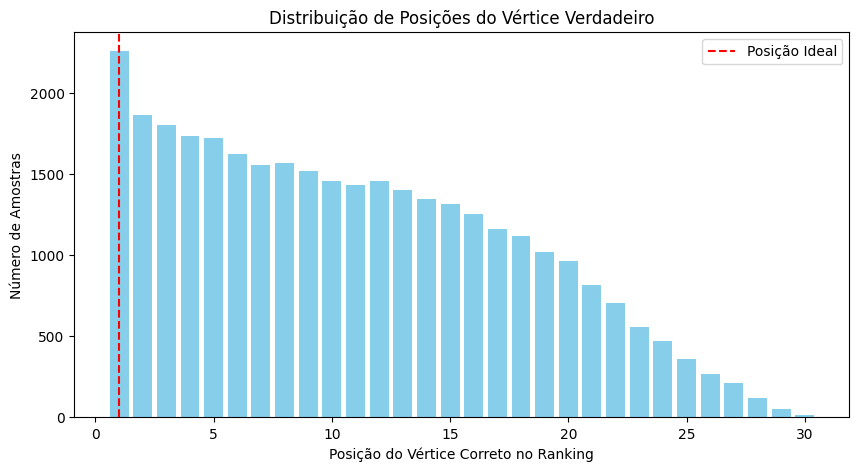

In [ ]:
print("Carregando o modelo branch...")
modelo_branch = load_model(final_model_dnn_path)
print("Testando o modelo branch...")
y_test, previsoes = testar_modelo(modelo_branch, files_teste, False)

print("\nMétricas Globais:")
accuracy_at_1 = np.mean([top_k_accuracy(y, p, k=1) for y, p in zip(y_test, previsoes)])
accuracy_at_2 = np.mean([top_k_accuracy(y, p, k=2) for y, p in zip(y_test, previsoes)])
accuracy_at_3 = np.mean([top_k_accuracy(y, p, k=3) for y, p in zip(y_test, previsoes)])
mrr_global = np.mean([reciprocal_rank(y, p) for y, p in zip(y_test, previsoes)])

print(f"Accuracy@1 (Global): {accuracy_at_1 * 100:.2f}%")
print(f"Accuracy@2 (Global): {accuracy_at_2 * 100:.2f}%")
print(f"Accuracy@3 (Global): {accuracy_at_3 * 100:.2f}%")
print(f"MRR (Global): {mrr_global:.4f}")
print(f"Rank Relativo Médio: {relative_rank(y_test, previsoes):.4f}")

plot_position_distribution(y_test, previsoes)

Carregando o modelo bound...


/home/igor/anaconda3/envs/tcc/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Testando o modelo bound...
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step
MAE: 0.9292
MSE: 1.5241
RMSE: 1.2346
R²: 1.0000


/home/igor/anaconda3/envs/tcc/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


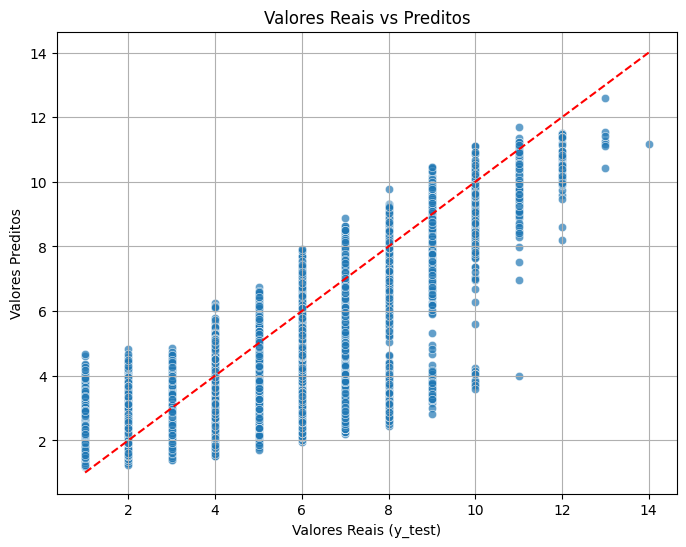

In [12]:
print("Carregando o modelo bound...")
modelo_bound = load_model(final_model_value_path)
print("Testando o modelo bound...")
y_test, previsoes = testar_modelo(modelo_bound, files_teste, True)

# MAE
mae = mae(y_test, previsoes)
print(f'MAE: {mae:.4f}')

# MSE
mse = mse(y_test, previsoes)
print(f'MSE: {mse:.4f}')

# RMSE
rmse = rmse(y_test, previsoes)
print(f'RMSE: {rmse:.4f}')

# R2
r2 = r2(y_test, previsoes)
print(f'R²: {r2:.4f}')

plot_predictions(y_test, previsoes)